In [41]:
import pandas as pd
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import scipy

import re

#Data handling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import seaborn


import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline


#  HOLD IT HERE
# with open(root_path + session_folders[4]+ forced_alignment + sentences_folders[0] +'/'+audio_files[0].split('.')[0] + '.wdseg','r') as openFile:
#     for line in openFile.readlines():
#         line = line.strip().split()
#         print(line)
# audio_files[0].split('.')[0] + '.wdseg'
# root_path + session_folders[4]+ forced_alignment + sentences_folders[0] +audio_files[0].split('.')[0] + '.wdseg'

In [2]:
def generate_IEMOCAP_df():
    root_path = 'data/IEMOCAP_full_release/'
    folders = os.listdir(root_path)
    session_folders = filter(lambda x: x.startswith('Session'),folders)
    sentences_wav = '/sentences/wav/'
    forced_alignment = '/sentences/ForcedAlignment/'
    dialog_transcriptions = '/dialog/transcriptions/' #Ses01F_impro01.txt
    dialog_emo = '/dialog/EmoEvaluation/' #Ses01F_impro01.txt
    data = {}
    emotions = {}
    for session in session_folders:
        temp_root = root_path + session
        temp_conversations_path = temp_root + sentences_wav
        temp_transcripts_path = temp_root + dialog_transcriptions
        temp_emo_path = temp_root + dialog_emo
        emo_eval = os.listdir(temp_emo_path)
        for emo_file in emo_eval:
            emo_file_path = temp_emo_path + emo_file
            if(emo_file.endswith('.txt')):
                with open(emo_file_path,'r') as openFile:
                    for line in openFile.readlines():
                        if(line.startswith('[')):
                            line = line.split()
                            key = line[3]
                            emotion = line[4]
                            valence = re.search('[0-9]+.[0-9]+', line[5]).group(0)
                            arousal = re.search('[0-9]+.[0-9]+',line[6]).group(0)
                            dominance = re.search('[0-9]+.[0-9]+',line[7]).group(0)
                            emotions[key] = [emotion,valence,arousal, dominance]
        transcriptions = os.listdir(temp_transcripts_path)
        for transcript in transcriptions:
            transcript_path = temp_transcripts_path + transcript
            with open(transcript_path,'r') as openFile:
                for line in openFile.readlines():
                    if(line.startswith('Ses')):
                        line = line.split(' [')
                        key = line[0]
                        if('XX' not in key):
                            line = ' ['.join(line[1:])
                            line = line.split(']: ')
                            time = line[0]
                            script = ']: '.join(line[1:])
                            start_t, end_t = time.split('-')
                            data[key] = [start_t,end_t,script.split('\r\n')[0]]
        conversations = os.listdir(temp_conversations_path)
        for conversation in conversations:
            files_path = temp_conversations_path+conversation
            files = os.listdir(files_path)
            for file in files:
                key,suf = file.split('.')
                if(suf == 'wav'):
                    data[key].append(files_path + '/'+ file)
    sentence_df = pd.DataFrame(data,index=['start_time','end_time','text','wav_path']).T
    emotion_df = pd.DataFrame(emotions, index=['emotion','valence','arousal','dominance']).T
    full = sentence_df.join(emotion_df)
    return full

In [3]:
# full = generate_IEMOCAP_df()
data = pd.read_csv('data/IEMOCAP_sentences.csv',index_col=0)
data =data.reset_index()

In [4]:
#full.to_csv('data/IEMOCAP_sentences.csv')

#data = data[(data.emotion != 'oth')&(data.emotion != 'xxx')]
data.groupby('emotion').count()

,index,start_time,end_time,text,wav_path,valence,arousal,dominance
emotion,,,,,,,,
ang,1103,1103,1103,1103,1103,1103,1103,1103
dis,2,2,2,2,2,2,2,2
exc,1041,1041,1041,1041,1041,1041,1041,1041
fea,40,40,40,40,40,40,40,40
fru,1849,1849,1849,1849,1849,1849,1849,1849
hap,595,595,595,595,595,595,595,595
neu,1708,1708,1708,1708,1708,1708,1708,1708
oth,3,3,3,3,3,3,3,3
sad,1084,1084,1084,1084,1084,1084,1084,1084


In [5]:
emotional_mapping = {'ang': 0, 'sad': 1, 'exc': 2, 'neu': 3,'fru': 4,'hap': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data['emotion'] = data['emotion'].map( emotional_mapping ).astype(int)

In [19]:
#Exclude ['oth', 'xxx', 'dis', 'sur','fea']
data = data[data.emotion < 6]
y = data.emotion
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(5904, 9) (5904,)
(1476, 9) (1476,)


In [7]:
#test_file = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F001.wav'
def get_mfcc_feature(filename,n_mfcc):
    y, sr = librosa.load(filename)
    #IPython.display.Audio(data=y,rate=sr)
    mfcc = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=n_mfcc)
    print("Finished "+ filename)
    return np.mean(mfcc.T,axis=0)

def map_for_emotion(y_list, emotional_mapping,emotion):
    return list(map(lambda x: 1 if x == emotional_mapping[emotion] else 0,y_list))

In [52]:
x_train = list(map(lambda x: get_mfcc_feature(x,20),X_train['wav_path']))

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav


array([-4.36326425e+02,  1.33105471e+02, -2.90027684e+01,  5.63991472e+01,
       -1.49388876e+01,  1.55891284e+01, -2.35098240e+00, -1.93070431e+00,
        6.67672561e+00, -9.66613058e+00,  9.84282276e+00, -5.29731822e+00,
        4.53843371e+00,  2.40311936e-01,  8.28772318e-01,  2.16480737e+00,
       -4.52063935e+00,  3.39211142e+00, -3.29787014e+00,  1.74515391e-01])

In [10]:
x_test = list(map(lambda x: get_mfcc_feature(x,20),X_test['wav_path']))

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F022.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F014.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F054.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F046.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F028.

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F02

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F038.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F01

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M030.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M044.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M041.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M046.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F013.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F041.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F027.wav
Fi

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F041.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_sc

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F017.wa

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M036.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav
Finish

# MFCC (20) Features - ang, sad, exc, neu, fru, hap

In [12]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

## Models

### Logistic Regression

In [29]:
def log_reg(x_train,y_train,x_test,y_test, delete = True):
    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)
    Y_pred = logreg.predict(x_test)
    acc_log = round(logreg.score(x_test, y_test) * 100, 2)
    if(delete):
        del logreg
        return Y_pred, acc_log
    return logreg,Y_pred,acc_log

# _, acc_log = log_reg(x_train,ang_train, x_test, ang_test)
# print(acc_log)

### SVC

In [30]:
def svc(x_train,y_train,x_test,y_test, delete = True):
    svc = SVC()
    svc.fit(x_train,y_train)
    Y_svcpred = svc.predict(x_test)
    acc_svc = round(svc.score(x_test, y_test) * 100,2)
    if(delete):
        del svc 
        return Y_svcpred, acc_svc
    return svc, Y_svcpred, acc_svc

# _, acc_svc = svc(x_train,ang_train,x_test,ang_test)
# print(acc_svc)

### K Nearest Neighbors

In [31]:
def knn(x_train,y_train,x_test,y_test,n_neighbors = 3,delete = True):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(x_train, y_train)
    Y_knnpred = knn.predict(x_test)
    acc_knn = round(knn.score(x_test, y_test) * 100, 2)
    if(delete):
        del knn
        return Y_knnpred, acc_knn
    return knn, Y_knnpred, acc_knn    
# _,acc_knn = knn(x_train,ang_train,x_test,ang_test)
# print(acc_knn)

### Gaussian Naive Bayes

In [32]:
def gaussian(x_train,y_train,x_test,y_test,delete = True):
    gaussian = GaussianNB()
    gaussian.fit(x_train, y_train)
    Y_gaussianpred = gaussian.predict(x_test)
    acc_gaussian = round(gaussian.score(x_test, y_test) * 100, 2)
    if(delete):
        del gaussian
        return Y_gaussianpred, acc_gaussian
    return gaussian, Y_gaussianpred, acc_gaussian

# _, acc_gaussian = gaussian(x_train,ang_train,x_test,ang_test)
# print(acc_gaussian)

### Perceptron

In [33]:
def perceptron(x_train,y_train,x_test,y_test,delete = True):
    perceptron = Perceptron()
    perceptron.fit(x_train, y_train)
    Y_perceptronpred = perceptron.predict(x_test)
    acc_perceptron = round(perceptron.score(x_test, y_test) * 100, 2)
    if(delete):
        del perceptron
        return Y_perceptronpred, acc_perceptron
    return perceptron, Y_perceptronpred ,acc_perceptron
# _, acc_perceptron = perceptron(x_train,ang_train,x_test,ang_test)
# print(acc_perceptron)

### Linear SVC

In [34]:
def linear_svc(x_train,y_train,x_test,y_test,delete = True):
    linear_svc = LinearSVC()
    linear_svc.fit(x_train, y_train)
    Y_linearsvcpred = linear_svc.predict(x_test)
    acc_linear_svc = round(linear_svc.score(x_test, y_test) * 100, 2)
    if(delete):
        del linear_svc
        return Y_linearsvcpred, acc_linear_svc
    return linear_svc, Y_linearsvcpred, acc_linear_svc
# _, acc_linear_svc = linear_svc(x_train,ang_train,x_test,ang_test)
# print(acc_linear_svc)

### Stochastic Gradient Descent

In [35]:
def sgd(x_train,y_train,x_test,y_test,delete = True):
    sgd = SGDClassifier()
    sgd.fit(x_train, y_train)
    Y_linearsgdpred = sgd.predict(x_test)
    acc_sgd = round(sgd.score(x_test, y_test) * 100, 2)
    if(delete):
        del sgd
        return Y_linearsgdpred , acc_sgd
    return sgd, Y_linearsgdpred, acc_sgd
# _, acc_sgd = sgd(x_train,ang_train,x_test,ang_test)
# print(acc_sgd)

### Decision Tree

In [36]:
def decision_tree(x_train,y_train,x_test,y_test,delete = True):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(x_train, y_train)
    Y_dectreepred = decision_tree.predict(x_test)
    acc_decision_tree = round(decision_tree.score(x_test, y_test) * 100, 2)
    if(delete):
        del decision_tree
        return Y_dectreepred , acc_decision_tree
    return decision_tree, Y_dectreepred , acc_decision_tree
# _, acc_decision_tree = decision_tree(x_train,ang_train,x_test,ang_test)
# print(acc_decision_tree)

### Random Forest

In [37]:
def random_forest(x_train,y_train,x_test,y_test,n_estimators = 100, delete = True):
    random_forest = RandomForestClassifier(n_estimators= n_estimators)
    random_forest.fit(x_train, y_train)
    Y_pred = random_forest.predict(x_test)
    acc_random_forest = round(random_forest.score(x_test, y_test) * 100, 2)
    if(delete):
        del random_forest
        return Y_pred, acc_random_forest
    return random_forest, Y_pred, acc_random_forest
# _, acc_random_forest = random_forest(x_train,ang_train, x_test , ang_test)
# print(acc_random_forest)

## Models Comparison

In [38]:
def compare_models(x_train, y_train, x_test, y_test, delete_all = True):
    _,acc_svc = svc(x_train,y_train,x_test,y_test)
    _,acc_knn = knn(x_train,y_train,x_test,y_test)
    _,acc_log = log_reg(x_train,y_train,x_test,y_test)
    _,acc_random_forest = random_forest(x_train,y_train,x_test,y_test)
    _,acc_gaussian = gaussian(x_train,y_train,x_test,y_test)
    _,acc_perceptron = perceptron(x_train,y_train,x_test,y_test)
    _,acc_sgd = sgd(x_train,y_train,x_test,y_test)
    _,acc_linear_svc = linear_svc(x_train,y_train,x_test,y_test)
    _,acc_decision_tree =  decision_tree(x_train,y_train,x_test,y_test)
    models = pd.DataFrame({
        'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                  'Random Forest', 'Naive Bayes', 'Perceptron', 
                  'Stochastic Gradient Decent', 'Linear SVC', 
                  'Decision Tree'],
        'Score': [acc_svc, acc_knn, acc_log, 
                  acc_random_forest, acc_gaussian, acc_perceptron, 
                  acc_sgd, acc_linear_svc, acc_decision_tree]})
    return models.sort_values(by='Score', ascending=False)

### Anger

In [23]:
compare_models(x_train,ang_train, x_test , ang_test)

,Model,Score
3,Random Forest,87.67
2,Logistic Regression,86.65
6,Stochastic Gradient Decent,86.45
7,Linear SVC,85.84
0,Support Vector Machines,85.16
1,KNN,84.28
8,Decision Tree,78.46
4,Naive Bayes,78.05
5,Perceptron,46.95


### Sadness

In [24]:
compare_models(x_train,sad_train, x_test , sad_test)

,Model,Score
3,Random Forest,87.94
2,Logistic Regression,87.13
6,Stochastic Gradient Decent,86.38
7,Linear SVC,85.84
1,KNN,85.23
0,Support Vector Machines,85.16
8,Decision Tree,81.91
4,Naive Bayes,80.49
5,Perceptron,69.31


### Excitement

In [25]:
compare_models(x_train,exc_train, x_test , exc_test)

,Model,Score
3,Random Forest,86.79
7,Linear SVC,86.25
0,Support Vector Machines,86.18
2,Logistic Regression,86.11
6,Stochastic Gradient Decent,85.84
5,Perceptron,84.82
1,KNN,84.49
8,Decision Tree,78.12
4,Naive Bayes,75.41


### Neutral

In [26]:
compare_models(x_train,neu_train, x_test , neu_test)

,Model,Score
3,Random Forest,78.05
2,Logistic Regression,77.03
0,Support Vector Machines,76.36
6,Stochastic Gradient Decent,76.36
7,Linear SVC,76.36
1,KNN,73.78
5,Perceptron,72.56
8,Decision Tree,70.66
4,Naive Bayes,66.06


### Frustration 

In [27]:
compare_models(x_train,fru_train, x_test , fru_test)

,Model,Score
3,Random Forest,76.15
0,Support Vector Machines,75.61
5,Perceptron,75.61
6,Stochastic Gradient Decent,75.61
7,Linear SVC,75.61
2,Logistic Regression,75.47
4,Naive Bayes,71.48
1,KNN,68.63
8,Decision Tree,65.79


### Happiness

In [28]:
compare_models(x_train,hap_train, x_test , hap_test)

,Model,Score
0,Support Vector Machines,91.53
2,Logistic Regression,91.53
3,Random Forest,91.53
5,Perceptron,91.53
7,Linear SVC,91.53
4,Naive Bayes,91.46
6,Stochastic Gradient Decent,91.40
1,KNN,90.04
8,Decision Tree,85.70


# RMSE

In [ ]:
#x_trainmfcc = list(map(lambda x: get_mfcc_feature(x,20),X_train['wav_path']))

def get_rmse(filename):
    y, sr = librosa.load(filename)
    rmse = librosa.feature.rmse(y)
    print("Finished "+ filename)
    return rmse[0]

test_file = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F010.wav'
rmse = get_rmse(test_file)
rmse.shape

In [68]:
x_train = list(map(lambda x: get_rmse(x),X_train['wav_path']))
x_test = list(map(lambda x: get_rmse(x),X_test['wav_path']))

In [69]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

## Models

In [78]:
# svc(x_train,ang_train, x_test , ang_test)


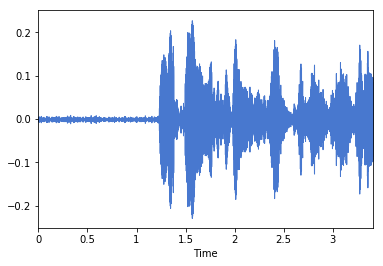

In [28]:
librosa.display.waveplot(y,sr=sr)

In [29]:
Y = librosa.stft(y)

In [30]:
Ymag = librosa.power_to_db(Y)

/usr/local/lib/python2.7/site-packages/librosa/core/spectrum.py:863: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(magphase(D, power=2)[0]) instead.
  warnings.warn('power_to_db was called on complex input so phase '


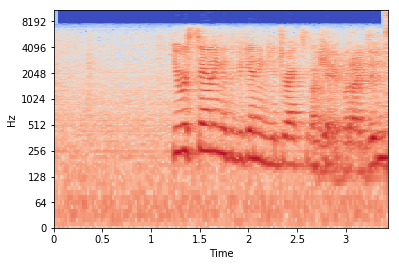

In [31]:

# Play with the parameters, including x_axis and y_axis# Play with the paramete 
librosa.display.specshow(Ymag, sr=sr, x_axis='time', y_axis='log')

In [32]:
onset_frames = librosa.onset.onset_detect(y, sr=sr)
print onset_frames

[ 16  48  54  60  65  76  84  87  96 101 104 111 115 120 130 134 140]


In [33]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
print onset_times

[0.37151927 1.11455782 1.25387755 1.39319728 1.50929705 1.76471655
 1.95047619 2.02013605 2.22911565 2.34521542 2.41487528 2.57741497
 2.67029478 2.78639456 3.0185941  3.11147392 3.25079365]


In [34]:
onset_samples = librosa.frames_to_samples(onset_frames)
print onset_samples

[ 8192 24576 27648 30720 33280 38912 43008 44544 49152 51712 53248 56832
 58880 61440 66560 68608 71680]


In [35]:
clicks = librosa.clicks(times=onset_times,length=len(y))

In [36]:
ipd.Audio(y, rate=sr)

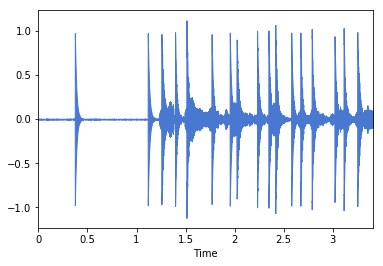

In [37]:
librosa.display.waveplot(y+clicks,sr=sr)

In [38]:
frame_sz = int(0.200*sr)
segments = np.array([y[i:i+frame_sz] for i in onset_samples])

In [39]:
def concatenate_segments(segments, sr=22050, pad_time = 0.300):
    padded_segments = [np.concatenate([segment,np.zeros(int(pad_time*sr))]) for segment in segments]
    return np.concatenate(padded_segments)

In [40]:
concatenated_signal = concatenate_segments(segments,sr)

In [41]:
ipd.Audio(concatenated_signal, rate=sr)

In [55]:
zcrs = [sum(librosa.core.zero_crossings(segment)) for segment in segments]
print zcrs

[231, 237, 367, 550, 385, 155, 170, 123, 210, 269, 311, 247, 303, 289, 315, 259, 93]


In [56]:
sum(librosa.core.zero_crossings(y))

4247

In [54]:
def get_word_segments(align_file):
    segments = []
    with open(align_file,'r') as openFile:
        read_lines = openFile.readlines()
        lines = read_lines[1:len(read_lines)-1]
        for line in lines:
            splitted = line.split()
            segments.append({'sf': splitted[0], 'ef':splitted[1],'seg_scr':splitted[2],'word':splitted[3]})
    return segments

In [52]:
# get_word_segments(test_align)

In [58]:
ind = np.argsort(zcrs)
print(ind)

[16  7  5  6  8  0  1 11 15  9 13 12 10 14  2  4  3]


In [59]:
concatenated_signal = concatenate_segments(segments[ind],sr)

In [60]:
ipd.Audio(concatenated_signal,rate=sr)

In [76]:
rmse = [sum(librosa.feature.rmse(segment)) for segment in segments]